In [2]:
import os
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
warnings.filterwarnings("ignore")


def load_data(file_path , filename):
    
    csv_path = os.path.join(file_path, filename)
    return pd.read_csv(csv_path)

In [3]:
def write_csv_data(file_path, filename, df):
    csv_path = os.path.join(file_path, filename)
    df.to_csv(csv_path)
    
    if os.path.exists(csv_path) and os.path.getsize(csv_path) > 0:
        print(filename + " was written to successfully!")

In [128]:
batting_file_path = "Data/2023"
bowling_file_path = "Data/2023"

batting_df = load_data(batting_file_path, "final_batting_2023.csv")
bowling_df = load_data(bowling_file_path, "final_bowling_2023.csv")

In [129]:
print(batting_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   POS     2341 non-null   int64  
 1   Player  2341 non-null   object 
 2   Mat     2341 non-null   int64  
 3   Inns    2341 non-null   int64  
 4   NO      2341 non-null   int64  
 5   Runs    2341 non-null   int64  
 6   HS      2341 non-null   object 
 7   Avg     2341 non-null   object 
 8   BF      2341 non-null   int64  
 9   SR      2341 non-null   float64
 10  100     2341 non-null   int64  
 11  50      2341 non-null   int64  
 12  4s      2341 non-null   int64  
 13  6s      2341 non-null   int64  
 14  year    2341 non-null   int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 274.5+ KB
None


In [130]:
print(bowling_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1471 non-null   int64  
 1   POS         1471 non-null   int64  
 2   Player      1471 non-null   object 
 3   Mat         1471 non-null   int64  
 4   Inns        1471 non-null   int64  
 5   Ov          1471 non-null   float64
 6   Runs        1471 non-null   int64  
 7   Wkts        1471 non-null   int64  
 8   BBI         1471 non-null   object 
 9   Avg         1471 non-null   float64
 10  Econ        1471 non-null   float64
 11  SR          1471 non-null   float64
 12  4w          1471 non-null   int64  
 13  5w          1471 non-null   int64  
 14  year        1471 non-null   int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 172.5+ KB
None


In [131]:
def cleanBattingData(df_batting, team_names):
    # Handles cleaning the Average column
    df_batting['Avg'] = df_batting['Avg'].astype(str)
    df_batting['Avg'] = df_batting['Avg'].str.replace("-", "0")
    df_batting['Avg'] = df_batting['Avg'].str.strip("")
    df_batting['Avg'] = df_batting['Avg'].astype('float64')

    # Removing unneeded * from High Score column
    df_batting['HS'] = df_batting['HS'].str.replace("*", "")
    
    if 'POS' in df_batting.columns:
        # Dropping unneeded POS column
        df_batting.drop(['POS'], axis=1, inplace=True)

    #if 'year' in df_batting.columns:
        # Dropping unneeded POS column
    #    df_batting.drop(['year'], axis=1, inplace=True)

    def remove_team_names(text):
        for team in team_names:
            text = text.replace(team, '')
        return text
    
    df_batting['Player'] = df_batting['Player'].apply(remove_team_names)

    
    return df_batting

In [132]:
team_names = ['RR', 'RCB', 'CSK', 'MI', 'GT', 'PBKS', 'LSG', 'SRH', 'PWI', 'DC', 'KKR', 'RPS', 'GL', 'KTK', 'DEC']
df_batting_clean = cleanBattingData(batting_df, team_names)

write_csv_data("Outputs/2023/Cleaned_Datasets", "cleaned_batting.csv", df_batting_clean)

cleaned_batting.csv was written to successfully!


In [133]:
def aggregate_batting(df):
    # This is used to concatenate the dataframes and count the number of seasons each player played by counting the duplicates
    df_season_count = df['Player'].value_counts().reset_index()
    # We will rename the columns for the this dataframe to easily merge into the total dataframe
    df_season_count = df_season_count.rename(columns={"count": "Seasons"})
    
    # This concatenation will produce the actual total dataframe with unique entries for each player because of groupby
    df_all = df.groupby(['Player']).agg({'Mat': 'sum', 'Inns': 'sum', 'NO': 'sum', 'Runs': 'sum', 'HS': 'max', 'Avg': 'mean', 'BF': 'sum', 'SR': 'mean', '100': 'sum', '50': 'sum', '4s': 'sum', '6s': 'sum', 'year': 'max'}).reset_index()
    # We merge the season count into the total dataframe to add the Season column
    df_all_with_season_count = df_all.merge(df_season_count, on='Player', how='left')

    return df_all_with_season_count

In [151]:
df_batting_grouped = aggregate_batting(df_batting_clean)
print(len(df_batting_grouped))
write_csv_data("Outputs/2023/Grouped", "grouped_batting.csv", df_batting_grouped)

627
grouped_batting.csv was written to successfully!


In [135]:
df_batting_grouped[df_batting_grouped['Player'] == 'Virat Kohli']

,Player,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,50,4s,6s,year,Seasons
602,Virat Kohli,237,229,34,7263,99,37.4325,5586,127.37625,7,50,643,234,2023,16


In [136]:
def cleanBowlingData(df_bowling, team_names):
    if 'POS' in df_bowling.columns:
        # Dropping unneeded POS column
        df_bowling.drop(['POS'], axis=1, inplace=True)

    if 'BBI' in df_bowling.columns:
        # Dropping unneeded BBI column
        df_bowling.drop(['BBI'], axis=1, inplace=True)

#    if 'year' in df_bowling.columns:
        # Dropping unneeded POS column
#        df_bowling.drop(['year'], axis=1, inplace=True)

    if 'Unnamed: 0' in df_bowling.columns:
        df_bowling.drop(['Unnamed: 0'], axis=1, inplace=True)

    def remove_team_names(text):
        for team in team_names:
            text = text.replace(team, '')
        return text
    
    df_bowling['Player'] = df_bowling['Player'].apply(remove_team_names)
    
    return df_bowling

In [142]:
df_bowling_clean = cleanBowlingData(bowling_df, team_names)

write_csv_data("Outputs/2023/Cleaned_Datasets", "cleaned_bowling.csv", df_bowling_clean)

cleaned_bowling.csv was written to successfully!


In [146]:
def agrgegate_bowling(df):
    # This is used to concatenate the dataframes and count the number of seasons each player played by counting the duplicates
    df_season_count = df['Player'].value_counts().reset_index()
    # We will rename the columns for the this dataframe to easily merge into the total dataframe
    df_season_count = df_season_count.rename(columns={"count": "Seasons"})
    
    # This concatenation will produce the actual total dataframe with unique entries for each player because of groupby
    df_all = df.groupby(['Player']).agg({'Mat': 'sum', 'Inns': 'sum', 'Ov': 'sum', 'Runs': 'sum', 'Wkts': 'sum', 'Avg': 'mean', 'Econ': 'mean', 'SR': 'mean', '4w': 'sum', '5w': 'sum', 'year': 'max'}).reset_index()
    # We merge the season count into the total dataframe to add the Season column
    df_all_with_season_count = df_all.merge(df_season_count, on='Player', how='left')

    return df_all_with_season_count

In [152]:
df_bowling_grouped = agrgegate_bowling(df_bowling_clean)
print(len(df_bowling_grouped))

write_csv_data("Outputs/2023/Grouped", "grouped_bowling.csv", df_bowling_grouped)

428
grouped_bowling.csv was written to successfully!


In [154]:
df_bowling_grouped.head()

,Player,Mat,Inns,Ov,Runs,Wkts,Avg,Econ,SR,4w,5w,year,Seasons
0,Aaron Finch,14,3,4.0,49,1,49.000000,12.250000,24.0,0,0,2013,1
1,Aavishkar Salvi,2,2,8.0,66,3,22.000000,8.250000,16.0,0,0,2011,1
2,Abdul Samad,12,3,7.0,96,1,96.000000,13.710000,42.0,0,0,2020,1
3,Abhimanyu Mithun,14,14,41.0,397,7,46.733333,10.563333,27.6,0,0,2013,3
4,Abhishek Jhunjhunwala,5,3,6.0,38,1,38.000000,6.330000,36.0,0,0,2012,1


In [155]:
numerical_columns = df_batting_grouped.select_dtypes(include=['int', 'float'])
numerical_columns.corr()['Runs'].sort_values(ascending=False)

Runs       1.000000
BF         0.996502
4s         0.984603
50         0.957583
Inns       0.952186
6s         0.934013
Mat        0.822271
Seasons    0.754898
100        0.648994
NO         0.636000
Avg        0.568991
SR         0.273810
year       0.265945
Name: Runs, dtype: float64

In [156]:
numerical_columns = df_bowling_grouped.select_dtypes(include=['int', 'float'])
numerical_columns.corr()['Wkts'].sort_values(ascending=False)

Wkts       1.000000
Runs       0.983420
Ov         0.982596
Inns       0.965513
Mat        0.906967
Seasons    0.884909
4w         0.710187
5w         0.439132
year       0.327947
SR        -0.057042
Avg       -0.125250
Econ      -0.219237
Name: Wkts, dtype: float64

In [231]:
# Get players that had their most recent season in 2020 and above
df_batting_grouped = df_batting_grouped[df_batting_grouped['year'] >= 2023]
print(len(df_batting_grouped))

df_bowling_grouped = df_bowling_grouped[df_bowling_grouped['year'] >= 2023]
print(len(df_bowling_grouped))

166
113


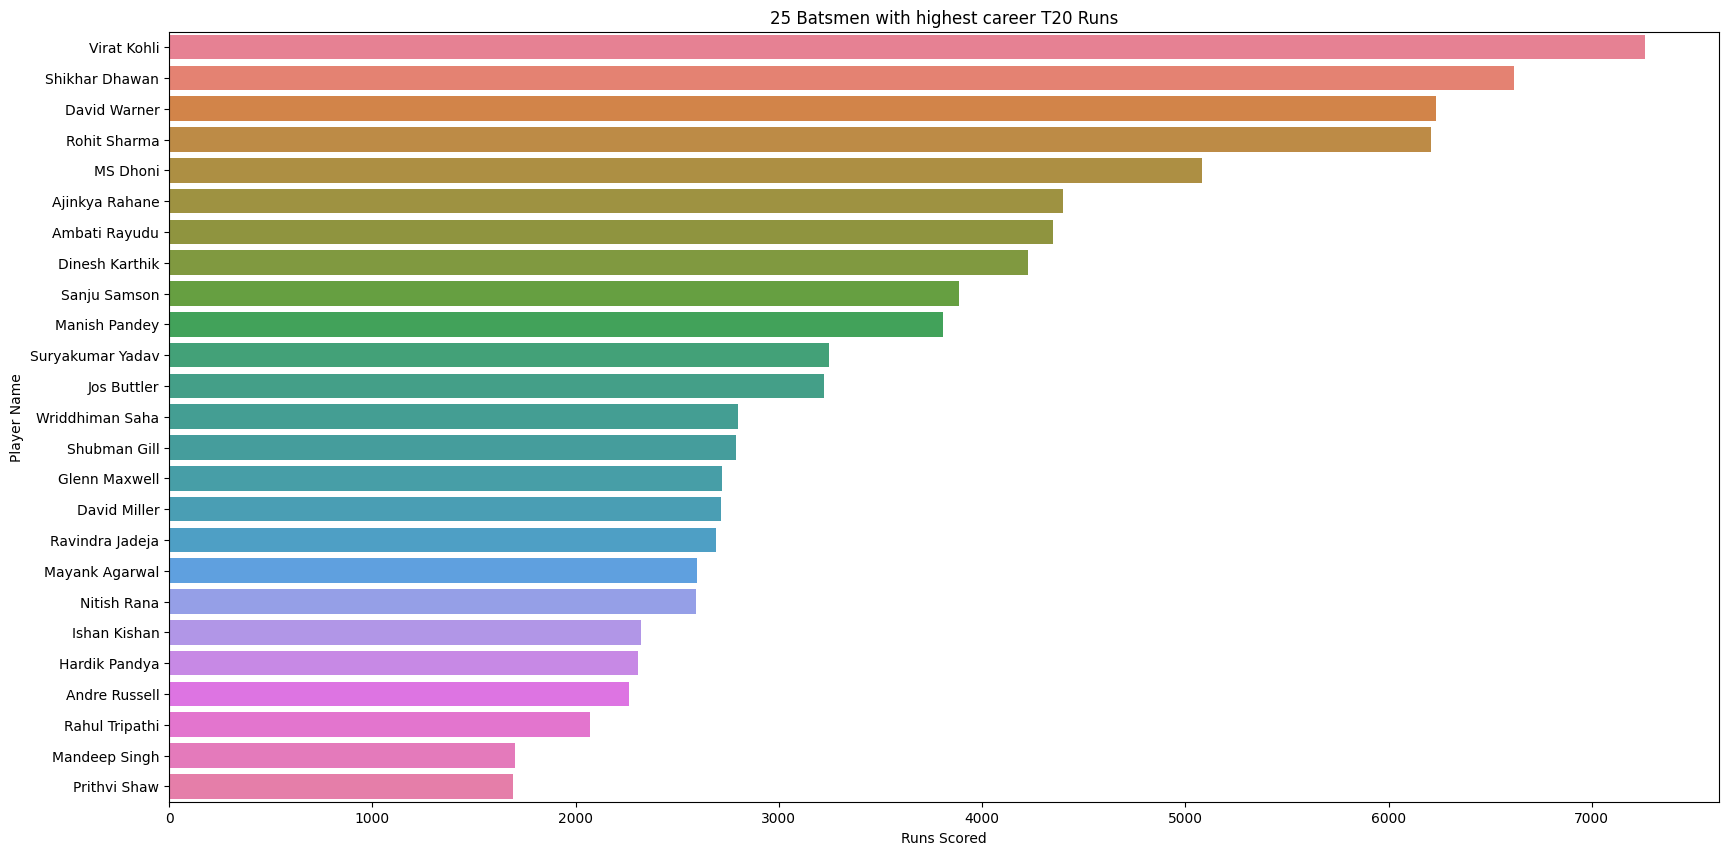

In [232]:
df_most_runs = df_batting_grouped.sort_values(by = ['Runs'], ascending = False)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Batsmen with highest career T20 Runs")
ax = sns.barplot(x = df_most_runs["Runs"], y = df_most_runs["Player"], palette = "husl")
ax.set(ylabel="Player Name", xlabel="Runs Scored")
plt.show()

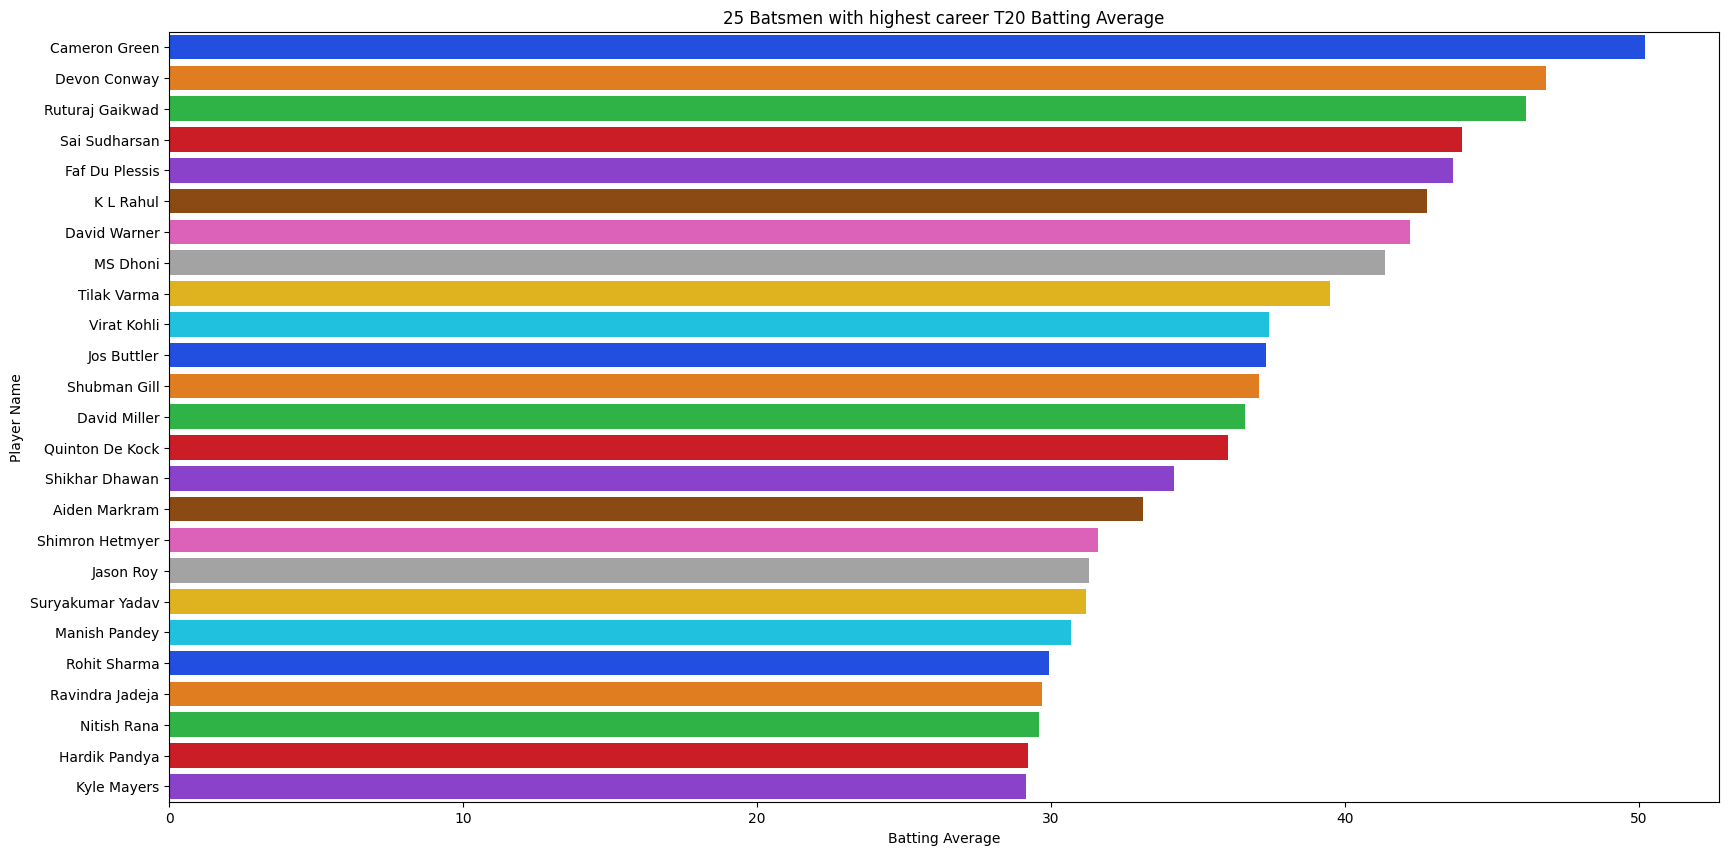

In [233]:
df_highest_avg = df_batting_grouped[df_batting_grouped['BF'] >= 200].sort_values(by = ['Avg'], ascending = False)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Batsmen with highest career T20 Batting Average")
ax = sns.barplot(x = df_highest_avg["Avg"], y = df_highest_avg["Player"], palette = "bright");
ax.set(ylabel="Player Name", xlabel="Batting Average")
plt.show()

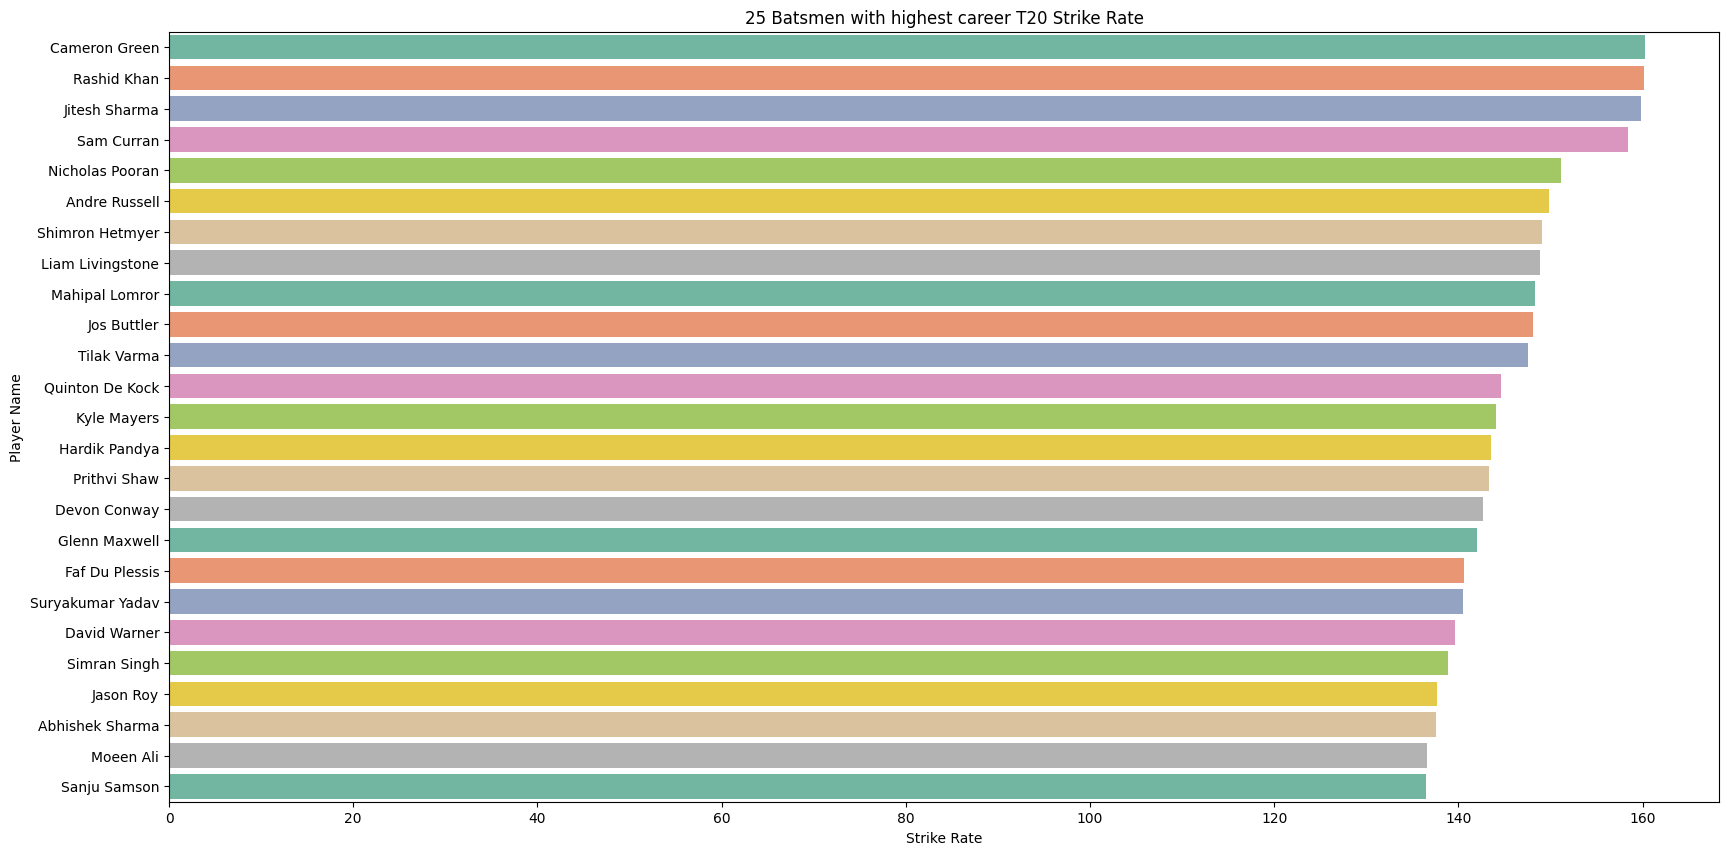

In [234]:
df_highest_strike_rate = df_batting_grouped[df_batting_grouped['BF'] >= 200].sort_values(by = ['SR'], ascending = False)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Batsmen with highest career T20 Strike Rate")
ax = sns.barplot(x = df_highest_strike_rate["SR"], y = df_highest_strike_rate["Player"], palette = "Set2");
ax.set(ylabel="Player Name", xlabel="Strike Rate")
plt.show()

In [235]:
df_batting_grouped[(df_batting_grouped['Avg'] >= 35) & (df_batting_grouped['SR'] >= 130)]

,Player,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,...,year,Seasons,Batting_Runs_Score,Batting_Avg_Score,Batting_SR_Score,Landmarks,Batting_Landmarks_Score,total_boundaries,Batting_total_boundaries_Score,Batting_Total_rating
110,Cameron Green,16,16,7,452,100,50.220000,282,160.280000,1,...,2023,1,1,5,5,3,1,62,2,14
144,David Miller,120,114,40,2714,94,36.608182,1961,131.698182,1,...,2023,11,5,5,4,13,3,313,5,22
145,David Warner,169,169,22,6234,93,42.220000,4440,139.616154,4,...,2023,13,5,5,4,64,5,851,5,24
154,Devon Conway,23,22,3,924,92,46.845000,654,142.680000,0,...,2023,2,2,5,5,9,2,129,3,17
181,Faf Du Plessis,30,30,2,1198,96,43.675000,842,140.600000,0,...,2023,2,3,5,5,11,3,158,4,20
253,Jos Buttler,96,95,10,3223,95,37.332500,2173,148.092500,5,...,2023,8,5,5,5,24,5,468,5,25
307,MS Dhoni,250,218,87,5082,84,41.352500,3739,136.455625,0,...,2023,16,5,5,4,24,5,588,5,24
419,Quinton De Kock,19,19,1,651,70,36.020000,443,144.580000,1,...,2023,2,2,5,5,5,1,88,2,15
468,Ruturaj Gaikwad,38,37,5,1429,92,46.163333,1035,134.823333,1,...,2023,3,3,5,4,12,3,185,4,19
477,Sai Sudharsan,13,13,2,507,96,43.980000,370,134.295000,0,...,2023,2,2,5,4,4,1,62,2,14


In [236]:
write_csv_data("Outputs/2023/Best_Players", "great_batsmen.csv", df_batting_grouped[(df_batting_grouped['Avg'] >= 35) & (df_batting_grouped['SR'] >= 130)])

great_batsmen.csv was written to successfully!


In [237]:
df_batting_grouped[(df_batting_grouped['Avg'] >= 40) & (df_batting_grouped['SR'] >= 140)]

,Player,Mat,Inns,NO,Runs,HS,Avg,BF,SR,100,...,year,Seasons,Batting_Runs_Score,Batting_Avg_Score,Batting_SR_Score,Landmarks,Batting_Landmarks_Score,total_boundaries,Batting_total_boundaries_Score,Batting_Total_rating
110,Cameron Green,16,16,7,452,100,50.220,282,160.28,1,...,2023,1,1,5,5,3,1,62,2,14
154,Devon Conway,23,22,3,924,92,46.845,654,142.68,0,...,2023,2,2,5,5,9,2,129,3,17
181,Faf Du Plessis,30,30,2,1198,96,43.675,842,140.60,0,...,2023,2,3,5,5,11,3,158,4,20
606,Vivrant Sharma,3,1,0,69,69,69.000,47,146.80,0,...,2023,1,1,1,1,1,1,11,1,5


In [238]:
write_csv_data("Outputs/2023/Best_Players", "exceptional_batsmen.csv", df_batting_grouped[(df_batting_grouped['Avg'] >= 40) & (df_batting_grouped['SR'] >= 140)])

exceptional_batsmen.csv was written to successfully!


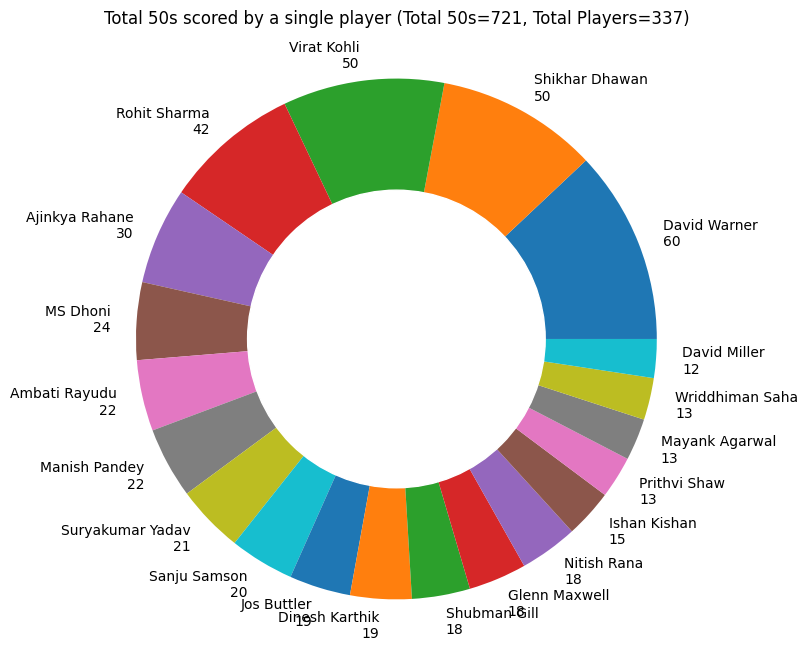

In [239]:
df_50 = df_batting_grouped.sort_values(by="50", ascending=False)[:20].copy()
df_50["custom_label"] = df_50["Player"] + "\n" + df_50["50"].astype(str)

plt.figure(figsize = (6, 8))
plt.pie(df_50["50"], labels=df_50["custom_label"], radius = 1.4, labeldistance=1.1, pctdistance=0.8)

circle = plt.Circle((0, 0), 0.8, color='white')
plt.title("Total 50s scored by a single player (Total 50s=721, Total Players=337)", pad=60)
plt.gca().add_artist(circle)
plt.show()

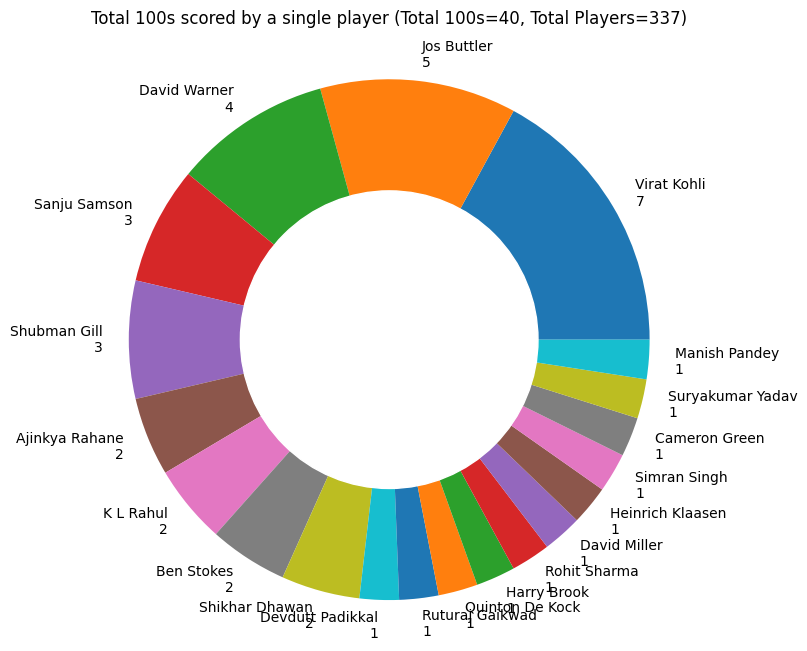

In [240]:
df_100 = df_batting_grouped.sort_values(by="100", ascending=False)[:20].copy()
df_100["custom_label"] = df_100["Player"] + "\n" + df_100["100"].astype(str)

plt.figure(figsize = (6, 8))
plt.pie(df_100["100"], labels=df_100["custom_label"], radius = 1.4, labeldistance=1.1, pctdistance=0.8)

circle = plt.Circle((0, 0), 0.8, color='white')
plt.title("Total 100s scored by a single player (Total 100s=40, Total Players=337)", pad=60)
plt.gca().add_artist(circle)
plt.show()

In [241]:
# Writing a function to handle the rating labelling in a new column
def assignRatingForMetricBatting(df, column_name, buckets):
    labels = [1, 2, 3, 4, 5]
    df["Batting_" + column_name + "_Score"] = pd.cut(df[column_name], buckets,labels=labels)
    # Convert the categorical data into numerical format. The 1 is to offset from 0-4 to 1-5. 
    # Conditional below is to assign a 1 by default to all players that have not faced at least 200 balls to prevent data skews
    df["Batting_" + column_name + "_Score"] = np.where(df["BF"] >= 200, df["Batting_" + column_name + "_Score"].cat.codes + 1, 1)
    return df

In [242]:
# Will define the bucket as shown above and pass it to the helper function above to bucket it accordingly
runs_bucket = [-np.inf, 500, 1000, 1500, 2000, np.inf]
df_batting_grouped = assignRatingForMetricBatting(df_batting_grouped, "Runs", runs_bucket)

In [243]:
avg_bucket = [-np.inf, 10, 20, 30, 35, np.inf]
df_batting_grouped = assignRatingForMetricBatting(df_batting_grouped, "Avg", avg_bucket)

In [244]:
sr_bucket = [-np.inf, 50, 100, 120, 140, np.inf]
df_batting_grouped = assignRatingForMetricBatting(df_batting_grouped, "SR", sr_bucket)

In [245]:
df_batting_grouped["Landmarks"] = df_batting_grouped["50"] + df_batting_grouped["100"]

landmarks_bucket = [-np.inf, 5, 10, 15, 20, np.inf]
df_batting_grouped = assignRatingForMetricBatting(df_batting_grouped, "Landmarks", landmarks_bucket)

In [246]:
df_batting_grouped["total_boundaries"] = df_batting_grouped["4s"] + df_batting_grouped["6s"]
boundaries_bucket = [-np.inf, 50, 100, 150, 200, np.inf]
df_batting_grouped = assignRatingForMetricBatting(df_batting_grouped, "total_boundaries", boundaries_bucket)

In [247]:
df_batting_grouped['Batting_Total_rating'] = df_batting_grouped["Batting_Runs_Score"] + df_batting_grouped["Batting_Avg_Score"] + df_batting_grouped["Batting_SR_Score"] + df_batting_grouped["Batting_Landmarks_Score"] + df_batting_grouped["Batting_total_boundaries_Score"]

In [248]:
df_batting_rating_system = df_batting_grouped.sort_values(by='Batting_Total_rating', ascending=False)[:75]
px.scatter(df_batting_rating_system, x="Runs", y="SR",
           size="Avg", color="Batting_Total_rating", hover_name="Player", size_max=55,title="Top 75 T20 Batsmen based on Rating System")

In [249]:
write_csv_data("Outputs/2023/Best_Players", "top_75_batsmen.csv", df_batting_rating_system)

top_75_batsmen.csv was written to successfully!


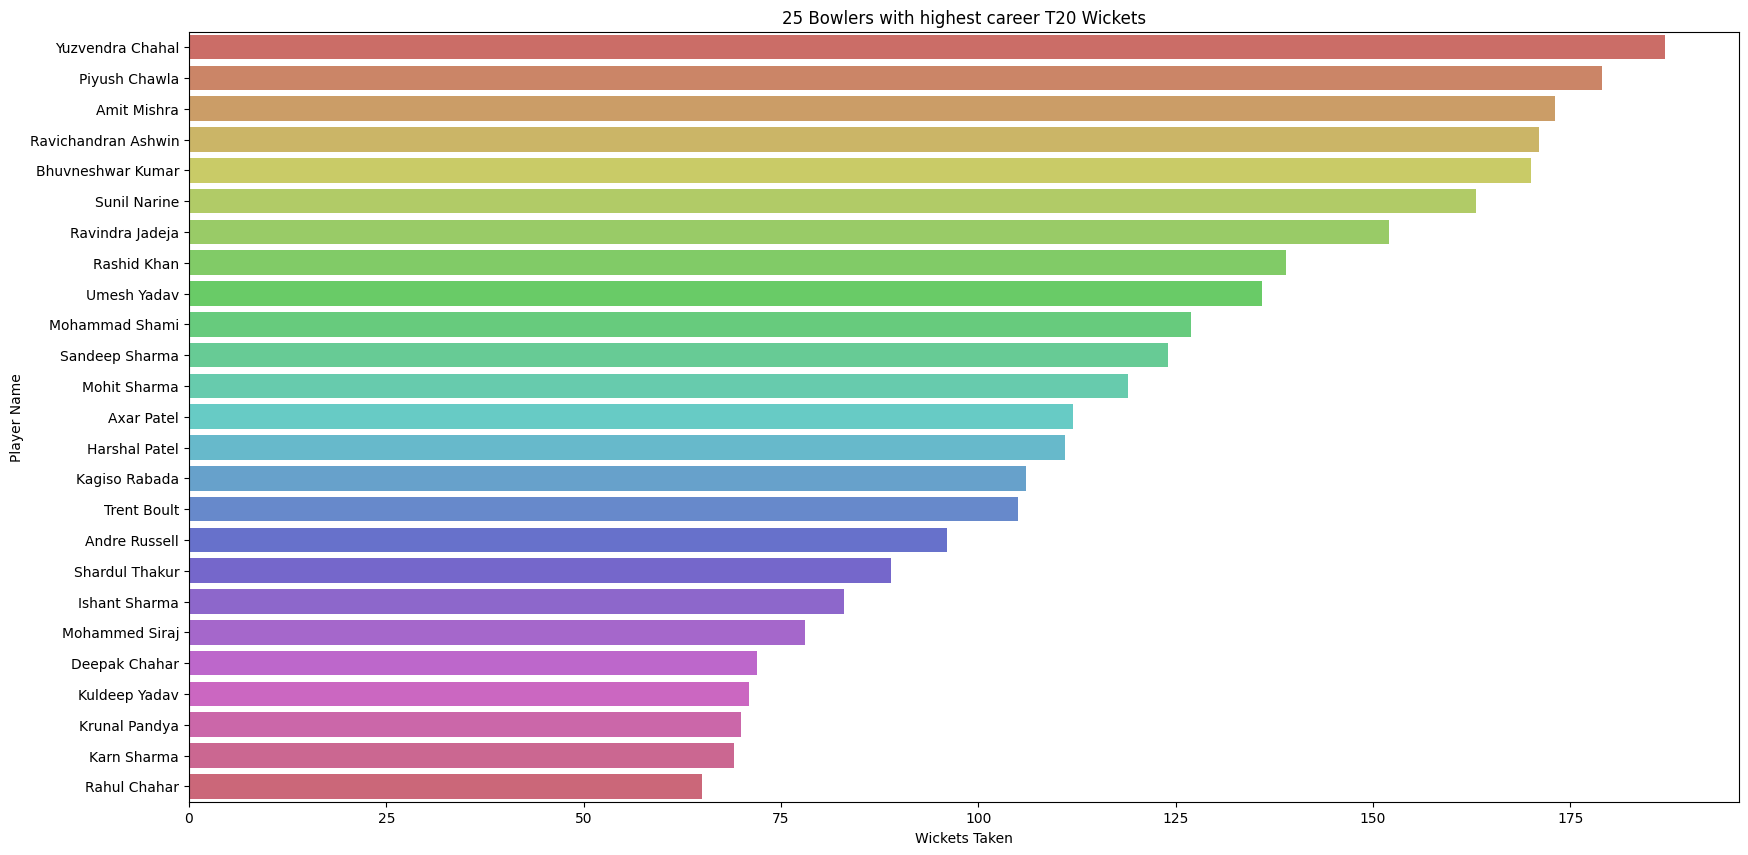

In [250]:
df_most_wickets = df_bowling_grouped.sort_values(by = ['Wkts'], ascending = False)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Bowlers with highest career T20 Wickets")
ax = sns.barplot(x = df_most_wickets["Wkts"], y = df_most_wickets["Player"], palette = "hls")
ax.set(ylabel="Player Name", xlabel="Wickets Taken")
plt.show()

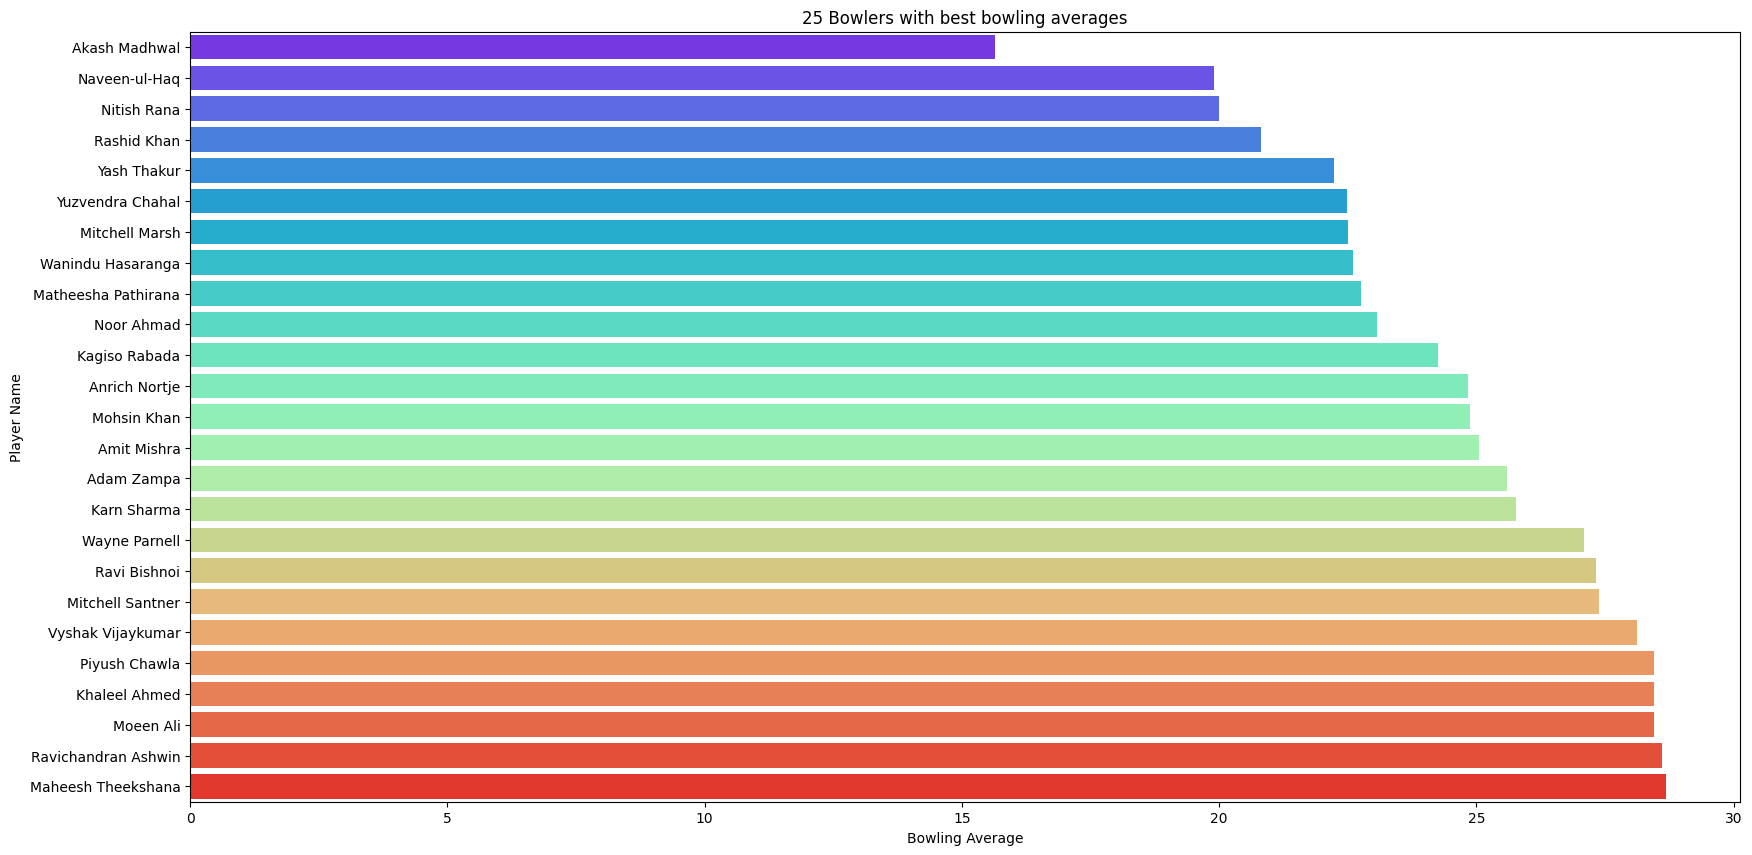

In [251]:
df_best_averages = df_bowling_grouped[df_bowling_grouped["Ov"] >= 20].sort_values(by = ['Avg'], ascending = True)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Bowlers with best bowling averages")
ax = sns.barplot(x = df_best_averages["Avg"], y = df_best_averages["Player"], palette = "rainbow")
ax.set(ylabel="Player Name", xlabel="Bowling Average")
plt.show()

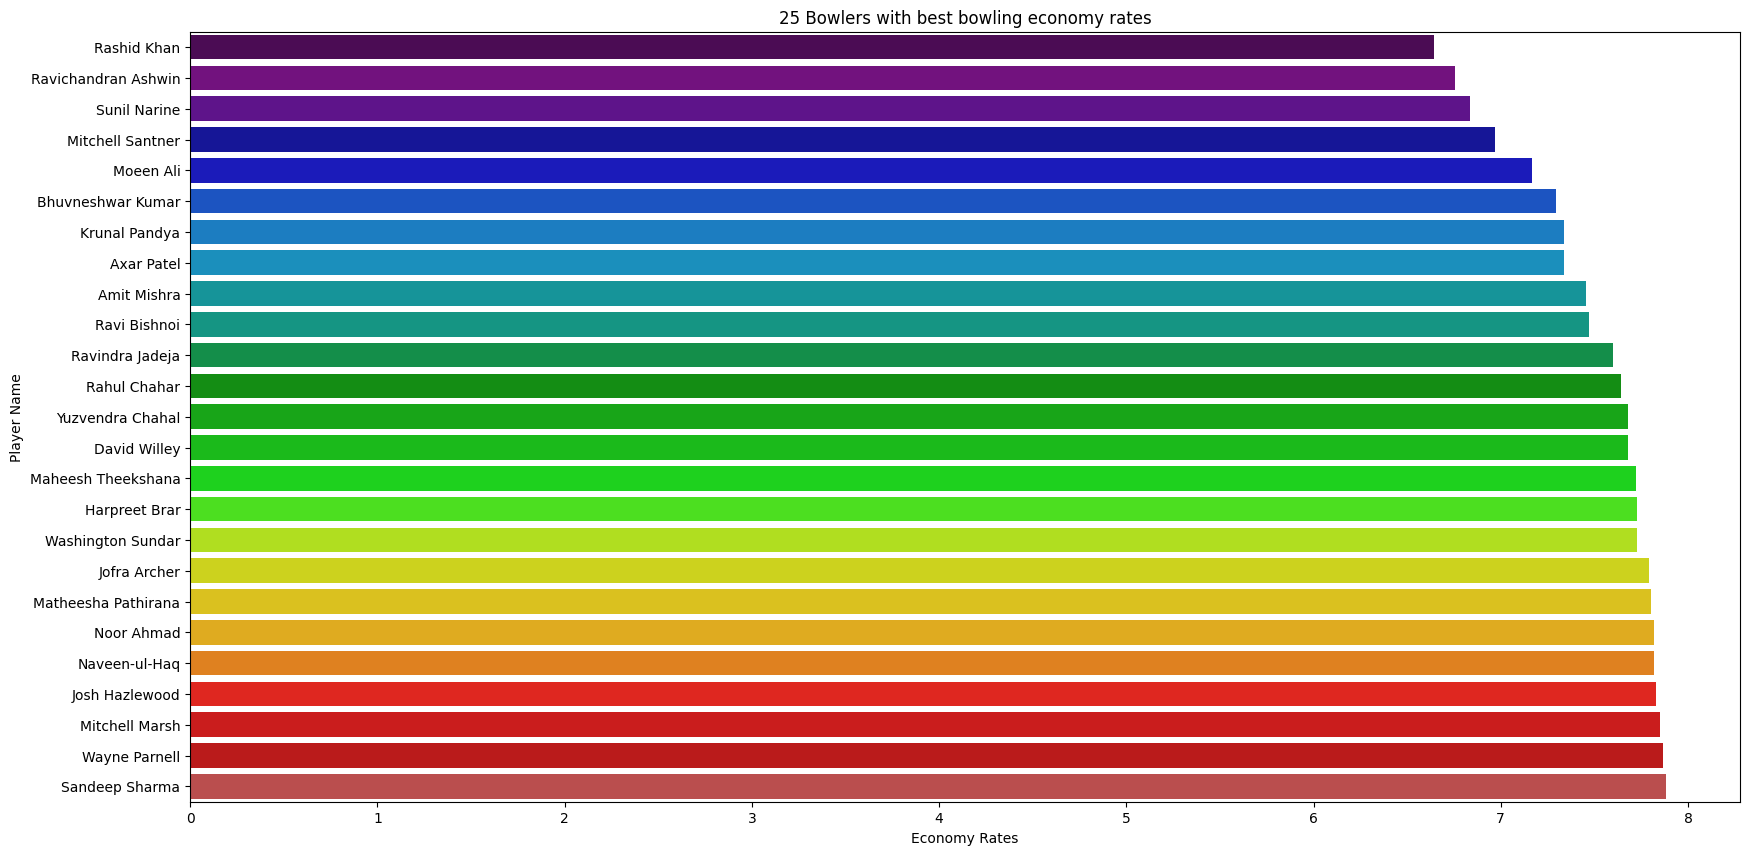

In [252]:
df_best_economy_rates = df_bowling_grouped[df_bowling_grouped["Ov"] >= 20].sort_values(by = ['Econ'], ascending = True)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Bowlers with best bowling economy rates")
ax = sns.barplot(x = df_best_economy_rates["Econ"], y = df_best_economy_rates["Player"], palette = "nipy_spectral")
ax.set(ylabel="Player Name", xlabel="Economy Rates")
plt.show()

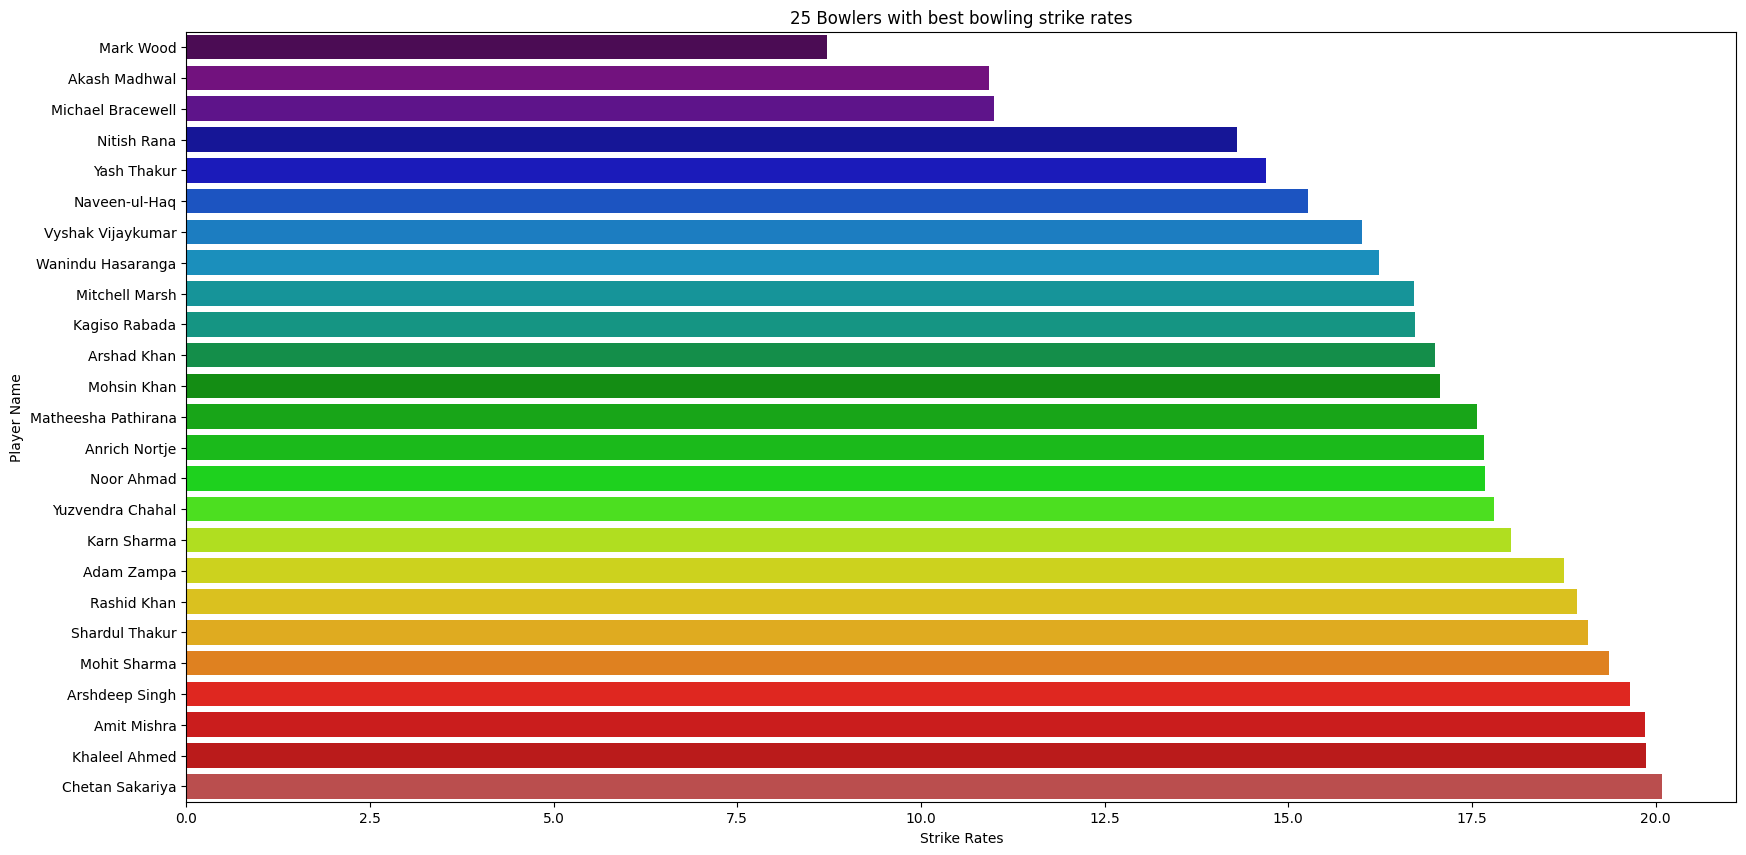

In [253]:
df_best_strike_rates = df_bowling_grouped[df_bowling_grouped["Ov"] >= 10].sort_values(by = ['SR'], ascending = True)[:25].copy()
plt.figure(figsize = (20, 10))
plt.title("25 Bowlers with best bowling strike rates")
ax = sns.barplot(x = df_best_strike_rates["SR"], y = df_best_strike_rates["Player"], palette = "nipy_spectral")
ax.set(ylabel="Player Name", xlabel="Strike Rates")
plt.show()

In [254]:
great_bowlers = df_bowling_grouped[(df_bowling_grouped['Ov'] >= 10) & (df_bowling_grouped['Avg'] <= 27.5) & (df_bowling_grouped['Econ'] <= 8)].sort_values(by="Wkts", ascending=False)
great_bowlers

,Player,Mat,Inns,Ov,Runs,Wkts,Avg,Econ,SR,4w,5w,year,Seasons,Landmarks
426,Yuzvendra Chahal,144,143,523.5,4022,187,22.489000,7.680000,17.802000,6,1,2023,10,8
26,Amit Mishra,161,161,559.0,4129,173,25.040000,7.454000,19.856667,4,1,2023,15,6
300,Rashid Khan,109,109,432.5,2885,139,20.805714,6.644286,18.932857,2,0,2023,7,2
301,Ravi Bishnoi,52,51,190.3,1445,53,27.332500,7.472500,21.712500,0,0,2023,4,0
231,Mitchell Marsh,37,30,84.1,686,36,22.508333,7.851667,16.715000,2,0,2023,6,2
416,Wayne Parnell,33,33,120.1,937,35,27.094000,7.868000,21.302000,0,0,2023,5,0
9,Adam Zampa,20,20,70.0,558,29,25.590000,7.967500,18.750000,0,1,2023,4,2
224,Matheesha Pathirana,14,14,52.7,423,21,22.760000,7.800000,17.565000,0,0,2023,2,0
261,Noor Ahmad,13,13,47.1,369,16,23.060000,7.820000,17.680000,0,0,2023,1,0
233,Mitchell Santner,15,15,52.0,358,13,27.375000,6.967500,23.625000,0,0,2023,4,0


In [255]:
write_csv_data("Outputs/2023/Best_Players", "great_bowlers.csv", great_bowlers)

great_bowlers.csv was written to successfully!


In [256]:
exceptional_bowlers = df_bowling_grouped[(df_bowling_grouped['Ov'] >= 10) & (df_bowling_grouped['Avg'] <= 25) & (df_bowling_grouped['Econ'] <= 7.75)].sort_values(by="Wkts", ascending=False)
exceptional_bowlers

,Player,Mat,Inns,Ov,Runs,Wkts,Avg,Econ,SR,4w,5w,year,Seasons,Landmarks
426,Yuzvendra Chahal,144,143,523.5,4022,187,22.489000,7.680000,17.802000,6,1,2023,10,8
300,Rashid Khan,109,109,432.5,2885,139,20.805714,6.644286,18.932857,2,0,2023,7,2


In [257]:
write_csv_data("Outputs/2023/Best_Players", "exceptional_bowlers.csv", exceptional_bowlers)

exceptional_bowlers.csv was written to successfully!


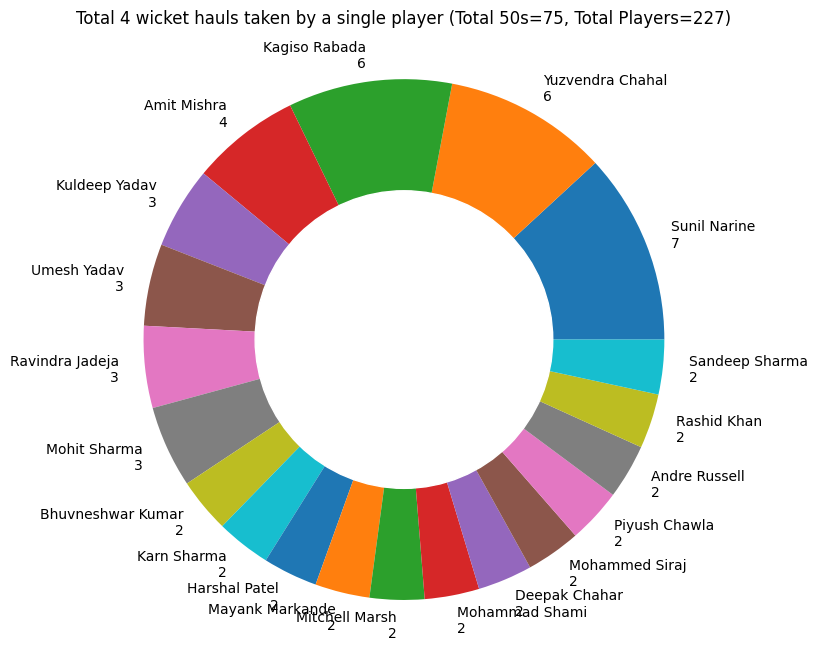

In [258]:
df_4w = df_bowling_grouped.sort_values(by="4w", ascending=False)[:20].copy()
df_4w["custom_label"] = df_4w["Player"] + "\n" + df_4w["4w"].astype(str)

plt.figure(figsize = (6, 8))
plt.pie(df_4w["4w"], labels=df_4w["custom_label"], radius = 1.4, labeldistance=1.1, pctdistance=0.8)

circle = plt.Circle((0, 0), 0.8, color='white')
plt.title("Total 4 wicket hauls taken by a single player (Total 50s=75, Total Players=227)", pad=60)
plt.gca().add_artist(circle)
plt.show()

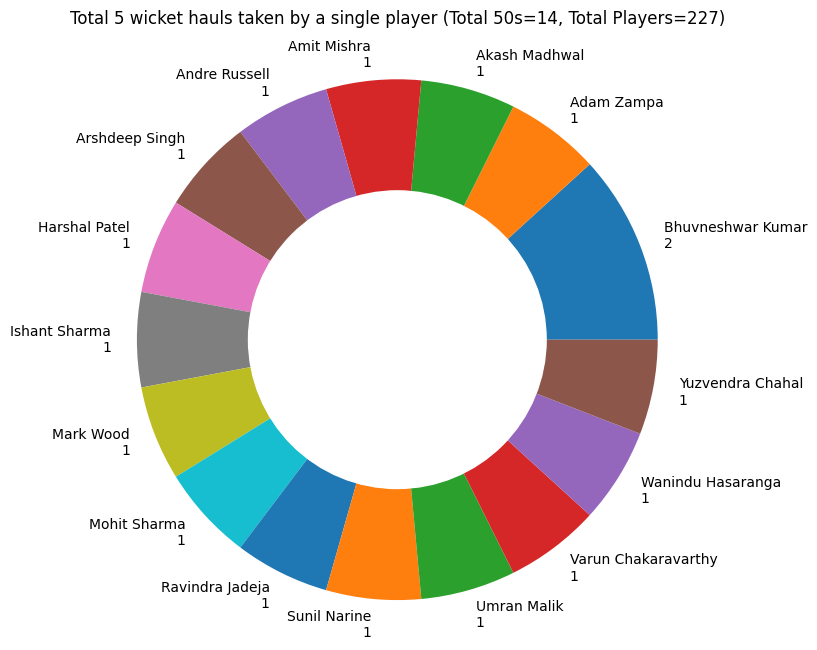

In [259]:
df_5w = df_bowling_grouped[df_bowling_grouped["5w"] > 0].sort_values(by="5w", ascending=False).copy()
df_5w["custom_label"] = df_5w["Player"] + "\n" + df_5w["5w"].astype(str)

plt.figure(figsize = (6, 8))
plt.pie(df_5w["5w"], labels=df_5w["custom_label"], radius = 1.4, labeldistance=1.1, pctdistance=0.8)

circle = plt.Circle((0, 0), 0.8, color='white')
plt.title("Total 5 wicket hauls taken by a single player (Total 50s=14, Total Players=227)", pad=60)
plt.gca().add_artist(circle)
plt.show()

In [260]:
# Writing a function to handle the rating labelling in a new column
def assignRatingForMetricBowling(df, column_name, buckets):
    label = [1, 2, 3, 4, 5]
    df["Bowling_" + column_name + "_Score"] = pd.cut(df[column_name], buckets,labels=label)
    # Convert the categorical data into numerical format. The 1 is to offset from 0-4 to 1-5.
    # Conditional below is to assign a 1 by default to all players that have not bowled at least 10 overs to prevent data skews
    df["Bowling_" + column_name + "_Score"] = np.where(df["Ov"] >= 10, df["Bowling_" + column_name + "_Score"].cat.codes + 1, 1)
    return df

In [261]:
# Need to add a landmarks column so the count of 4 wicket hauls and 5 wicket hauls per bowler will be aggregated.
df_bowling_grouped["Landmarks"] = df_bowling_grouped["4w"] + (df_bowling_grouped["5w"] * 2)

df_bowling_rating = df_bowling_grouped.copy()

# Converting all of the columns below to negative since a lower one of these values means more ratings
df_bowling_rating["Econ"] = df_bowling_rating["Econ"] * -1
df_bowling_rating["Avg"] = df_bowling_rating["Avg"] * -1
df_bowling_rating["SR"] = df_bowling_rating["SR"] * -1

In [262]:
# Will define the bucket as shown above and pass it to the helper function above to bucket it accordingly
wicket_bucket = [-np.inf, 25, 50, 75, 100, np.inf]
df_bowling_rating = assignRatingForMetricBowling(df_bowling_rating, "Wkts", wicket_bucket)

In [263]:
# Need to use a reversed label since lower the average the better the score
average_bucket = [-np.inf, -35, -30, -25, -20, np.inf]
df_bowling_rating = assignRatingForMetricBowling(df_bowling_rating, "Avg", average_bucket)

In [264]:
# Need to use a reversed label since lower the strike rate the better the score
strike_rate_bucket = [-np.inf, -35, -27.5, -22.5, -17.5, np.inf]
df_bowling_rating = assignRatingForMetricBowling(df_bowling_rating, "SR", strike_rate_bucket)

In [265]:
# Need to use a reversed label since lower the economy rate the better the score
economy_bucket = [-np.inf, -9, -8.5, -8, -7.5, np.inf]
df_bowling_rating = assignRatingForMetricBowling(df_bowling_rating, "Econ", economy_bucket)

In [266]:
landmark_bucket = [-np.inf, 2, 3, 4, 5, np.inf]
df_bowling_rating = assignRatingForMetricBowling(df_bowling_rating, "Landmarks", landmark_bucket)

In [267]:
# Finally need to reset the the columns we made negatives back to being positive values
df_bowling_rating["Econ"] = df_bowling_rating["Econ"] * -1
df_bowling_rating["Avg"] = df_bowling_rating["Avg"] * -1
df_bowling_rating["SR"] = df_bowling_rating["SR"] * -1

In [268]:
df_bowling_rating['Bowling_Total_rating'] = df_bowling_rating["Bowling_Wkts_Score"] + df_bowling_rating["Bowling_Avg_Score"] + df_bowling_rating["Bowling_SR_Score"] + df_bowling_rating["Bowling_Landmarks_Score"] + df_bowling_rating["Bowling_Econ_Score"]

In [269]:
df_bowling_rating_system = df_bowling_rating.sort_values(by='Bowling_Total_rating', ascending=False)[:75]
px.scatter(df_bowling_rating_system, x="Wkts", y="Econ",
           size="Avg", color="Bowling_Total_rating", hover_name="Player", size_max=55,title="Top 75 T20 Bowlers based on Rating System")

In [270]:
write_csv_data("Outputs/2023/Best_Players", "top_75_bowlers.csv", df_bowling_rating_system)

top_75_bowlers.csv was written to successfully!


In [271]:
df_rating_batting = df_batting_grouped[['Player',  'Batting_Runs_Score', 'Batting_Avg_Score', 'Batting_SR_Score', 'Batting_Landmarks_Score', 'Batting_total_boundaries_Score', 'Batting_Total_rating']].copy()
df_rating_bowling = df_bowling_rating[['Player', 'Bowling_Wkts_Score', 'Bowling_Avg_Score', 'Bowling_SR_Score', 'Bowling_Landmarks_Score', 'Bowling_Econ_Score', 'Bowling_Total_rating']].copy()

In [272]:
df_rating_merged = df_rating_batting.merge(df_rating_bowling, on=['Player'], how='inner')

In [273]:
df_rating_merged['All_rounder_rating'] = (df_rating_merged['Batting_Total_rating'] + df_rating_merged['Bowling_Total_rating']) / 2

In [274]:
df_all_rounder_rating = df_rating_merged.sort_values(by='All_rounder_rating', ascending=False)[:50]

In [275]:
write_csv_data("Outputs/2023/Best_Players", "top_50_all_rounders.csv", df_all_rounder_rating)

top_50_all_rounders.csv was written to successfully!
